In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC

from sklearn.metrics import auc, roc_curve, roc_auc_score , accuracy_score, mean_squared_error, f1_score 


In [2]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_m1.csv')
df.head()

user_id   timestamp               event  \
0  668300627f964509a7f5b5f63b570d55  2024-02-18         first_visit   
1  668300627f964509a7f5b5f63b570d55  2024-03-04               visit   
2  668300627f964509a7f5b5f63b570d55  2024-03-16               visit   
3  668300627f964509a7f5b5f63b570d55  2024-03-30               visit   
4  668300627f964509a7f5b5f63b570d55  2024-04-26  visit_and_purchase   

                    params  age gender  
0        {'source': 'sns'}   31      M  
1                      NaN   31      M  
2                      NaN   31      M  
3                      NaN   31      M  
4  {'product': 'Clothing'}   31      M

‚úÖ Ï†ÑÏ≤òÎ¶¨ & EDA

In [3]:
# Params dictionary Ï≤òÎ¶¨ 
df['param_dic'] = df['params'].fillna('{}').map(eval)

# Source / Product ÏÉùÏÑ± 
df['source'] = df['param_dic'].str['source']
df['product'] = df['param_dic'].str['product']

# ÏãúÍ∞Ñ
df['timestamp'] = pd.to_datetime(df['timestamp'])

<Axes: xlabel='timestamp', ylabel='count'>

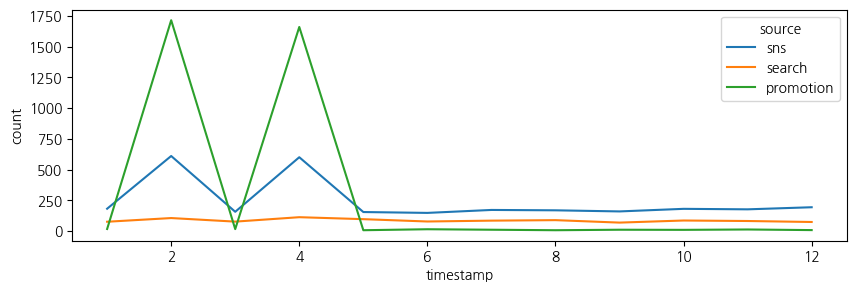

In [4]:
plot_df = df.groupby(df['timestamp'].dt.month)['source'].value_counts().reset_index()

plt.figure(figsize = (10, 3))
sns.lineplot(x = 'timestamp', y ='count', hue = 'source', data = plot_df)

In [5]:
# Ï≤´ Î∞©Î¨∏
first = df[df.event =='first_visit'][['user_id','timestamp']].rename(columns ={'timestamp':'first_visit_time'}).reset_index(drop=True)

# Ï≤´ Î∞©Î¨∏Í≥º Îç∞Ïù¥ÌÑ∞ Í≤∞Ìï© : Ï≤´Î∞©Î¨∏ Ïù¥ÌõÑÏùò ÎÇ†ÏßúÏùò Ï∞®Ïù¥ Íµ¨ÌïòÍ∏∞ 
m_df = pd.merge(df , first)
m_df['day_diff'] = (m_df['timestamp'] - m_df['first_visit_time']).dt.days

# Ïú†Ï†Ä 7ÏùºÏ∞®/ 31ÏùºÏ∞® Ïû¨ Î∞©Î¨∏Ïú®
len(m_df[m_df['day_diff'] == 7] )/ len(m_df.user_id.unique())
len(m_df[m_df['day_diff'] == 31] )/ len(m_df.user_id.unique())

0.028798277486206433

‚úÖ Í∞ÄÏûÖ ÌõÑ ÌïúÎã¨ÎèôÏïàÏùò Ïú†Ï†Ä ÌñâÎèôÏùÑ ÌÜµÌï¥ Îã§ÏùåÎã¨ Ï≤´Ï£º ÎèôÏïàÏùò Î¨ºÍ±¥ Íµ¨Îß§ Ïó¨Î∂ÄÎ•º ÌôïÏù∏ÌïòÎäî Î™®Îç∏ÎßÅÏùÑ ÏßÑÌñâ

In [6]:
# Í∞ÄÏûÖ ÌõÑ ÌïúÎã¨ 
df2 = m_df.copy()
df2 = df2.loc[df2.day_diff < 31].reset_index(drop = True)

# Î∞©Î¨∏ & Íµ¨Îß§ = 1 Î°ú ÏπòÌôò 
df2['purchase'] = df2.apply(lambda x : 1 if x['event'] == 'visit_and_purchase' else 0 , axis = 1)
df2 = df2.drop(columns = ['params', 'param_dic'], axis = 1)

In [7]:
# source, product ÎùºÎ≤® Ïù∏ÏΩîÎî© 
df2['new_param'] = df2['source'].astype(str) + '_' + df2['product'].astype(str)

In [8]:
num_df = df2[['age','gender','day_diff','purchase']]
dummies_df = pd.get_dummies(df2['new_param'], dtype = 'int')

model_df = pd.concat([num_df, dummies_df], axis = 1) 

Í∞ÄÏûÖÏùº Ìè¨Ìï® Ï≤´ 31Ïùº ÎèôÏïàÏùò Ïú†Ï†Ä ÌñâÎèôÏùÑ ÌÜµÌï¥ 32ÏùºÏß∏ Î∂ÄÌÑ∞ 7ÏùºÎèôÏïàÏùò Î¨ºÍ±¥ Íµ¨Îß§ Ïó¨Î∂ÄÎ•º ÌôïÏù∏ÌïòÎäî Î™®Îç∏ÎßÅ </br>
 ÌíÄÏù¥Î∞©Î≤ï] </br>
1. Ï≤´ Í∞ÄÏûÖ ÏùºÏûêÎ•º Íµ¨ÌïòÍ∏∞ </br>
2. day_diff Î°ú ÎÇ†Ïßú Ï∞®Ïù¥ Íµ¨ÌïòÍ∏∞</br>
3. Í∞ÄÏûÖ 30Ïùº ÏïàÏóê ÎìúÎäî Í∑∏Î£π Íµ¨ÌïòÍ∏∞ = g </br>
         3.1 Ï≤òÏùå Î∞©Î¨∏Ìïú user_idÎ≥Ñ ÏÜåÏä§, ÎÇòÏù¥, ÏÑ±Î≥Ñ (basic_info)</br>
         3.2 Í∞ÄÏûÖ 30Ïùº ÏïàÏóê Îì† user_idÏóêÏÑú visit_and_purchaseÏùò Ï¥ù Íµ¨Îß§ Í±¥Ïàò (total_purchase)</br>
         3.3 Í∞ÄÏûÖ 30Ïùº ÏïàÏóê Îì† user_idÏóêÏÑú visit_and_purchaseÏùò Ï†úÌíàÎ≥Ñ Íµ¨Îß§Í±¥ÏàòÎ•º user_idÍ∏∞Ï§Ä Ìñâ/Ïó¥ ÏπòÌôò (products)</br>
         3.4 Í∞ÄÏûÖ 30Ïùº ÏïàÏóê Îì† user_idÏóêÏÑú visit Ïùò Î∞©Î¨∏ ÌöüÏàò (visit)</br> 
4. 3Î≤à Ìï≠Î™© Î≥ëÌï© (user_id Í∏∞Ï§Ä)

In [9]:
# Ï≤´ Í∞ÄÏûÖ ÏùºÏßú Íµ¨ÌïòÍ∏∞ 
df['first_joined_day'] = df.groupby(['user_id'])['timestamp'].transform(lambda x : x.min())

# ÎÇ†Ïßú Ï∞®Ïù¥
df['day_diff'] = (df['timestamp'] - df['first_joined_day']).dt.days

In [10]:
# 1. Í∞ÄÏûÖ 30Ïùº ÏïàÏóê Ïú†Ï†ÄÎì§ Í∑∏Î£π 
g = df.loc[df['day_diff'] <= 30].reset_index(drop = True)

# Ï≤òÏùå Î∞©Î¨∏Ìïú ÏÇ¨Ïö©ÏûêÏùò ÏïÑÏù¥Îîî, ÏÜåÏä§, ÎÇòÏù¥, ÏÑ±Î≥Ñ - 7431 
basic_info = g[g.event == 'first_visit'][['user_id','source','age','gender']].reset_index(drop = True)
basic_info.head(3)

user_id source  age gender
0  668300627f964509a7f5b5f63b570d55    sns   31      M
1  5247c14484884949b5aa036cc68219f5    sns   47      M
2  3e2b6f742974459eba9d3aaa22f6da9c    sns   32      F

In [11]:
# Ï¥ù Íµ¨Îß§ ÌöüÏàò - 3490
total_purchase = g[g.event == 'visit_and_purchase']['user_id'].value_counts().reset_index().rename(columns = {'count' :'total_purchase'}) 
total_purchase.head(3)

user_id  total_purchase
0  b863bcb3866c4b0fb0a80f15d60bfb58               4
1  d946b67c899e4863afde979e581e6cb1               4
2  c141521cca514cc189ff6f0d06d9db62               4

In [12]:
# Í∞Å Î¨ºÌíàÎ≥Ñ Íµ¨Îß§ ÌöüÏàò - 3490
products = g[g.event  == 'visit_and_purchase'].groupby(['user_id','product']).size().unstack().fillna(0).astype(int).reset_index() 
products.head(3)

product                           user_id  Beauty Products  Books  Clothing  \
0        001d54a6141b41e0b44b01e5512b37e4                0      0         0   
1        002564a18b32492e9993f9bb09a570f7                0      0         0   
2        0025f3db50064e068aa9a515411b4cc0                0      0         0   

product  Electronics  Groceries  Home & Kitchen  Movies & TV  Music  Sports  \
0                  0          0               0            1      0       0   
1                  0          1               1            0      0       0   
2                  1          0               1            0      0       0   

product  Toys  
0           0  
1           0  
2           0

In [13]:
# Î∞©Î¨∏ ÌöüÏàò 4631
visit = g[g.event == 'visit']['user_id'].value_counts().reset_index().rename(columns = {'count' :'visit_cnt'})
visit.head(3)

user_id  visit_cnt
0  922f7952e9514a848aec7a7425865da5          5
1  a99e8f7238024679b4f742590d914e5c          5
2  2d08b20277c2473da4cca08190b2c250          5

In [14]:
m1 = pd.merge(basic_info, total_purchase, how = 'outer', on = 'user_id')
m2 = pd.merge(m1, products, how = 'outer', on = 'user_id')
m3 = pd.merge(m2, visit, how = 'outer', on = 'user_id')

m3= m3.fillna(0)

In [15]:
# 1. Í∞ÄÏûÖ 31ÏóêÏÑú 37 ÏÇ¨Ïù¥Ïóê ÏûàÎäî Ïú†Ï†ÄÎì§ Í∑∏Î£π - Íµ¨Îß§Ìïú ÏïÑÏù¥ÎîîÎì§ 
g3137 = df.loc[(df.day_diff >=31) & (df.day_diff <=37)].reset_index(drop = True)

y = g3137.groupby(['user_id', 'event']).size().unstack()['visit_and_purchase'].fillna(0).reset_index()


In [16]:
model = pd.merge(m3, y, how = 'outer', on = 'user_id').fillna(0)
model.head()

user_id     source  age gender  total_purchase  \
0  001ce1bb72964d909bc319705b8ffdbf  promotion   48      F             0.0   
1  001cec87aa1f4527b488781176ea3f25        sns   25      F             0.0   
2  001d54a6141b41e0b44b01e5512b37e4        sns   44      F             1.0   
3  0024a606685141279f350d2fdfeb9f9a        sns   28      F             0.0   
4  002564a18b32492e9993f9bb09a570f7        sns   45      F             2.0   

   Beauty Products  Books  Clothing  Electronics  Groceries  Home & Kitchen  \
0              0.0    0.0       0.0          0.0        0.0             0.0   
1              0.0    0.0       0.0          0.0        0.0             0.0   
2              0.0    0.0       0.0          0.0        0.0             0.0   
3              0.0    0.0       0.0          0.0        0.0             0.0   
4              0.0    0.0       0.0          0.0        1.0             1.0   

   Movies & TV  Music  Sports  Toys  visit_cnt  visit_and_purchase  
0          0.0    0.0     0.0   0.0        1.0                 0.0  
1          0.0    0.0     0.0   0.0        1.0                 0.0  
2          1.0    0.0     0.0   0.0        1.0                 0.0  
3          0.0    0.0     0.0   0.0        1.0                 0.0  
4          0.0    0.0     0.0   0.0        1.0                 0.0

‚úÖ ÎπÑÌä∏ÏΩîÏù∏ Í∞ÄÍ≤© Îç∞Ïù¥ÌÑ∞

In [17]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_m2.csv')
df.head()

TIMESTAMP  bitcoin($)
0  1.577837e+09     7195.24
1  1.577837e+09     7187.67
2  1.577837e+09     7184.41
3  1.577837e+09     7183.83
4  1.577837e+09     7185.54

‚úÖ Í≤∞Ï∏°Ïπò ÎåÄÏπò Î∞©Ïïà - ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞(Î≥¥Í∞ÑÎ≤ï)

In [18]:
df.columns = ['time','value']
df['time'] = pd.to_datetime(df['time'], unit = 's')
df.head()

df1 = df.interpolate(method = 'linear')

‚úÖ Îç∞Ïù¥ÌÑ∞Ïùò Ï†ïÏÉÅÏÑ±ÏùÑ ÌÜµÍ≥ÑÏ†Å,ÏãúÍ∞ÅÏ†Å Î∞©Î≤ïÏùÑ ÌÜµÌï¥ ÌôïÏù∏ </br>
1. Adufuller 
 - Í∑ÄÎ¨¥Í∞ÄÏÑ§ : ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Îã§ (v)
 - ÎåÄÎ¶ΩÍ∞ÄÏÑ§ : Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Îã§.

2. plot_acf, plot_pacf 

0.6911875407269488


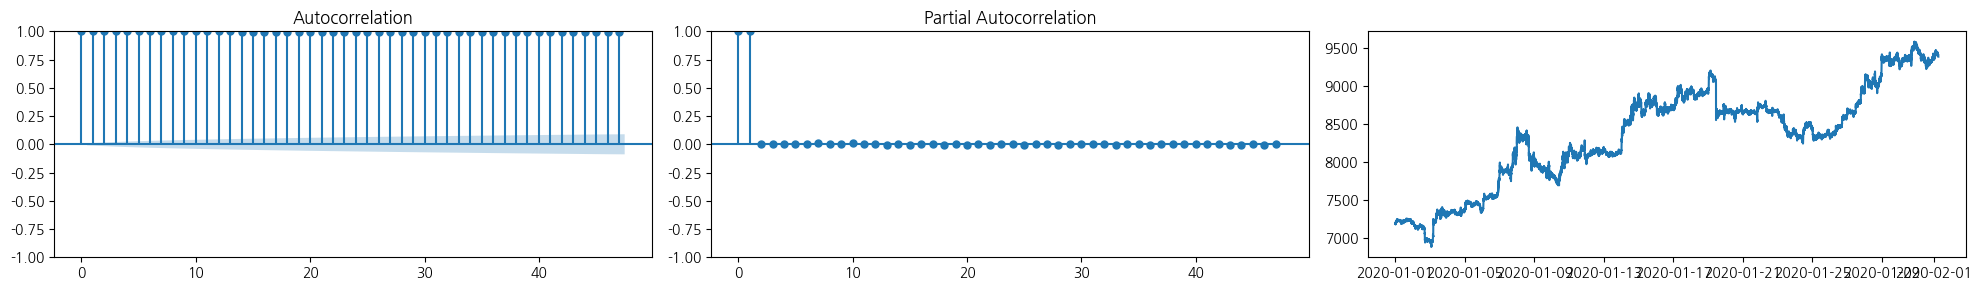


1. ACF Í∑∏ÎûòÌîÑ 
    - Ï†ïÏÉÅ : ACFÍ∞íÏù¥ Îπ†Î•¥Í≤å 0Ïóê ÏàòÎ†¥, lagÍ∞Ä Ï¶ùÍ∞ÄÌï®Ïóê Îî∞Îùº Í∏âÍ≤©Ìûà Í∞êÏÜå 
    - ÎπÑÏ†ïÏÉÅ : ACFÍ∞Ä Ï≤úÏ≤úÌûà Í∞êÏÜåÌïòÍ±∞ÎÇò, ÏßÄÏÜçÏ†ÅÏúºÎ°ú ÎÜíÏùÄ ÏÉÅÍ¥ÄÍ≥ÑÏàò Ïú†ÏßÄ 
     ÏßÄÏÜçÏ†ÅÏù∏ ÏûêÍ∏∞ ÏÉÅÍ¥ÄÏù¥ ÏûàÏùå (Ï†ÑÌòïÏ†ÅÏù∏ ÎπÑÏ†ïÏÉÅ Ìå®ÌÑ¥)
2. PACF Í∑∏ÎûòÌîÑ 
    - Ï†ïÏÉÅ : PACF Í∞íÏù¥ ÌäπÏ†ï ÏãúÏ∞® Ïù¥ÌõÑ 0Ïóê ÏàòÎ†¥ 
    - ÎπÑÏ†ïÏÉÅ : PACF Í∞íÏù¥ ÏßÄÏÜçÏ†ÅÏúºÎ°ú Ïú†ÏùòÎØ∏Ìïú Í∞íÏùÑ Í∞ÄÏßê
    Lag 1ÏóêÏÑúÎßå ÌÅ∞ Í∞íÏùÑ Í∞ÄÏßÄÍ≥† ÏûàÏúºÎ©∞, AR(1)ÏùÑ ÏãúÏÇ¨ÌïòÏßÄÎßå, ACF Í∑∏ÎûòÌîÑÏóê Í∏∞Î∞òÌïòÏó¨ Ï†ïÏÉÅÏÑ± ÎùÑÏßÄ ÏïäÏùå 



In [19]:
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

result = adfuller(df1['value'])
print(result[1])

fig, ax = plt.subplots(1,3, figsize = (20, 3))
plot_acf(df1['value'], ax = ax[0])
plot_pacf(df1['value'], ax = ax[1])
plt.plot(df1['time'], df1['value'] )

plt.tight_layout()
plt.show()

print('''
1. ACF Í∑∏ÎûòÌîÑ 
    - Ï†ïÏÉÅ : ACFÍ∞íÏù¥ Îπ†Î•¥Í≤å 0Ïóê ÏàòÎ†¥, lagÍ∞Ä Ï¶ùÍ∞ÄÌï®Ïóê Îî∞Îùº Í∏âÍ≤©Ìûà Í∞êÏÜå 
    - ÎπÑÏ†ïÏÉÅ : ACFÍ∞Ä Ï≤úÏ≤úÌûà Í∞êÏÜåÌïòÍ±∞ÎÇò, ÏßÄÏÜçÏ†ÅÏúºÎ°ú ÎÜíÏùÄ ÏÉÅÍ¥ÄÍ≥ÑÏàò Ïú†ÏßÄ 
     ÏßÄÏÜçÏ†ÅÏù∏ ÏûêÍ∏∞ ÏÉÅÍ¥ÄÏù¥ ÏûàÏùå (Ï†ÑÌòïÏ†ÅÏù∏ ÎπÑÏ†ïÏÉÅ Ìå®ÌÑ¥)
2. PACF Í∑∏ÎûòÌîÑ 
    - Ï†ïÏÉÅ : PACF Í∞íÏù¥ ÌäπÏ†ï ÏãúÏ∞® Ïù¥ÌõÑ 0Ïóê ÏàòÎ†¥ 
    - ÎπÑÏ†ïÏÉÅ : PACF Í∞íÏù¥ ÏßÄÏÜçÏ†ÅÏúºÎ°ú Ïú†ÏùòÎØ∏Ìïú Í∞íÏùÑ Í∞ÄÏßê
    Lag 1ÏóêÏÑúÎßå ÌÅ∞ Í∞íÏùÑ Í∞ÄÏßÄÍ≥† ÏûàÏúºÎ©∞, AR(1)ÏùÑ ÏãúÏÇ¨ÌïòÏßÄÎßå, ACF Í∑∏ÎûòÌîÑÏóê Í∏∞Î∞òÌïòÏó¨ Ï†ïÏÉÅÏÑ± ÎùÑÏßÄ ÏïäÏùå 
''')

<Figure size 2000x300 with 0 Axes>

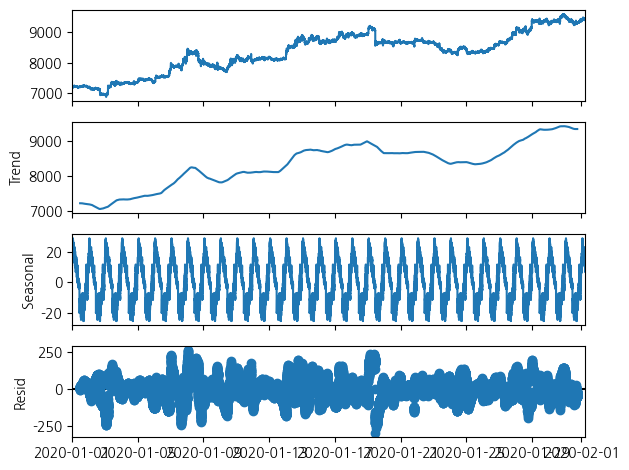


Îç∞Ïù¥ÌÑ∞Í∞Ä Ï∂îÏÑ∏, Í≥ÑÏ†àÏÑ±ÏùÑ Í∞ÄÏßÄÍ≥† ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê Ï∞®Î∂Ñ/Î≥ÄÌôòÏùÑ ÌÜµÌï¥ Ï†ïÏÉÅÏÑ±ÏùÑ ÌôïÎ≥¥ Ìïú ÌõÑ Î™®Îç∏Ïóê Ï†ÅÏö©ÌïòÎäîÍ≤ÉÏù¥ ÌïÑÏöî



In [20]:
result = seasonal_decompose(df1.set_index('time'), model='additive', period=1440)

plt.figure(figsize = (20,3))
result.plot()
plt.show()
print('''
Îç∞Ïù¥ÌÑ∞Í∞Ä Ï∂îÏÑ∏, Í≥ÑÏ†àÏÑ±ÏùÑ Í∞ÄÏßÄÍ≥† ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê Ï∞®Î∂Ñ/Î≥ÄÌôòÏùÑ ÌÜµÌï¥ Ï†ïÏÉÅÏÑ±ÏùÑ ÌôïÎ≥¥ Ìïú ÌõÑ Î™®Îç∏Ïóê Ï†ÅÏö©ÌïòÎäîÍ≤ÉÏù¥ ÌïÑÏöî
''')

### üîç ÌÜµÍ≥Ñ
##### ‚úÖ 1. ÎπÑÎ™®ÏàòÍ≤ÄÏ†ï

| ÌîºÌóòÏûê   | Ï∞®Îüâ A | Ï∞®Îüâ B | Ï∞®Îüâ C |
|----------|--------|--------|--------|
| ÌîºÌóòÏûê1 |   4    |   1    |   6    |
| ÌîºÌóòÏûê2 |   3    |   4    |   6    |
| ÌîºÌóòÏûê3 |   2    |   4    |   6    |
| ÌîºÌóòÏûê4 |   4    |   3    |   2    |
| ÌîºÌóòÏûê5 |   4    |   1    |   6    |
| ÌîºÌóòÏûê6 |   6    |   4    |   2    |
| ÌîºÌóòÏûê7 |   5    |   3    |   5    |
| ÌîºÌóòÏûê8 |   6    |   3    |   2    |
| ÌîºÌóòÏûê9 |   2    |   4    |   6    |


In [27]:
# Ï∞®ÎüâÏùò ÏåçÎ≥ÑÎ°ú ÎπÑÍµê - ÌîÑÎ¶¨ÎìúÎßå 
from scipy.stats import friedmanchisquare , chi2_contingency

A = [4,3,2,4,4,6,5,6,2]
B = [1,4,4,3,1,4,3,3,4]
C = [6,6,6,2,6,2,5,2,6]

s, p_val = friedmanchisquare(A,B,C)
print(p_val)

0.4124194827001596


##### ‚úÖ 2. Ïû•Î•¥Î≥Ñ ÌåùÏΩò Íµ¨Îß§Ïó¨Î∂Ä

In [25]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_s2.csv')
df.head()

Ïú†Ï†ÄID  Ïû•Î•¥ Íµ¨Îß§Ïó¨Î∂Ä
0     0  Ïï°ÏÖò   Íµ¨Îß§
1     1  Ïï°ÏÖò   Íµ¨Îß§
2     2  Ïï°ÏÖò   Íµ¨Îß§
3     3  Ïï°ÏÖò   Íµ¨Îß§
4     4  Ïï°ÏÖò   Íµ¨Îß§

In [28]:
tab = pd.crosstab(df['Ïû•Î•¥'] , df['Íµ¨Îß§Ïó¨Î∂Ä'])

stat, p_val, _, _ = chi2_contingency(tab)
print(p_val)

4.987377462630171e-14


#### üì¶ ÌÅ¨ÎùºÎ©îÎ•¥ Ïó∞Í¥ÄÍ≥ÑÏàò 
Îëê Î≤îÏ£ºÌòï Î≥ÄÏàòÍ∞ÑÏùò Ïó∞Í¥ÄÏÑ±ÏùÑ Ï∏°Ï†ïÌïòÎäî ÏßÄÌëú (Ïπ¥Ïù¥ Ï†úÍ≥± ÌÜµÍ≥ÑÎüâ Í∏∞Î∞ò)
- 0Ïóê Í∞ÄÍπåÏö∏ ÏàòÎ°ù Ïó∞Í¥ÄÏÑ± ÏóÜÏùå
- 1Ïóê Í∞ÄÍπåÏö∏ ÏàòÎ°ù Í∞ïÌïú Ïó∞Í¥ÄÏÑ±
- 0.6d Ïù¥ÏÉÅ Í∞ïÌïú Ïó∞Í¥Ä / 0.2 ~ 0.6 Ï†ÅÎãπÌûà Ïó∞Í¥Ä

In [34]:
# cross_tabÏùò Íµ¨Îß§Ïó¨Î∂ÄÏùò Ìï© 
total = tab.sum().sum()

# row ÌòπÏùÄ column Ïàò Ï§ë ÏûëÏùÄ Í∞í
k = min(tab.shape) 

np.sqrt(stat / total * (k -1))

np.float64(0.32916973606033734)

##### ‚úÖ 3. Ïñ¥Îäê ÎèÑÏãúÏóêÏÑú ÏÑ±Ïù∏ Ï†ÑÏ≤¥Ïùò 25%Í∞Ä Ìù°Ïó∞ÏûêÎùºÍ≥† ÌïúÎã§. ÎßåÏïΩ ÌòÑÏû¨ÎèÑ Ïù¥ÏôÄ ÎπÑÏä∑Ìïú ÎπÑÏú®Ïù¥ Ïú†ÏßÄÎêúÎã§Î©¥ 1300Î™ÖÏùò ÏÑ±Ïù∏ÌëúÎ≥∏ÏóêÏÑú Ìù°Ïó∞ÏûêÍ∞Ä 317Î™ÖÎ≥¥Îã§ ÏûëÏùÑ ÌôïÎ•† 

In [43]:
from scipy.stats import norm, binom
#Ïù¥Ìï≠Î∂ÑÌè¨Îäî ùëõÏù¥ ÌÅ¨Í≥† pÍ∞Ä Ï§ëÍ∞ÑÍ∞í(0.5 Í∑ºÏ≤ò)Ïùº Îïå Ï†ïÍ∑úÎ∂ÑÌè¨Î°ú Í∑ºÏÇ¨ > NÏù¥ 1300Î™ÖÏûÑÏúºÎ°ú Ï†ïÍ∑úÎ∂ÑÌè¨Î°ú ÌíÄÏù¥ 

p = 0.25 
n = 1300 
x = 316.5  # Ïó∞ÏÜçÏÑ± Î≥¥Ï†ï Ï†ÅÏö©

mean = n * p 
se = np.sqrt(n * p * (1-p))
# ZÏ†êÏàò
z = (x - mean) / se 

print(norm.cdf(z))


# <Ïù¥Ìï≠ ÌíÄÏù¥ Ï∞∏Í≥†> 
p = 0.25 
n = 1300 
x = 317

rv = binom(n, p)
# 317Î≥¥Îã§ ÏûëÏùÑ ÌôïÎ•† : 316Ïù¥Ìïò 
rv.cdf(x - 1)

0.29307083446132876


np.float64(0.2943747986304395)

##### ‚úÖ 4. ÏÇ¨Ïö©ÏûêÍ∞Ä Í≤åÏûÑ ÎÇ¥ÏóêÏÑú ÌäπÏ†ï ÌÄòÏä§Ìä∏Î•º ÌÅ¥Î¶¨Ïñ¥ÌïòÎäî ÏÑ±Í≥µ ÌôïÎ•†Ïù¥ 0.3
1) ÏÇ¨Ïö©ÏûêÍ∞Ä Ï¥ù 3ÌöåÏùò ÏÑ±Í≥µÏùÑ ÌïòÍ∏∞ÍπåÏßÄ ÏãúÎèÑÌïú ÌöüÏàòÍ∞Ä 5Ìöå ÎØ∏ÎßåÏùº ÌôïÎ•†
2) ÏÇ¨Ïö©ÏûêÍ∞Ä 4Î≤àÏùò ÌÄòÏä§Ìä∏ ÌÅ¥Î¶¨Ïñ¥ ÏÑ±Í≥µÏùÑ Í≤ΩÌóòÌïòÍ∏∞ÍπåÏßÄ ÌèâÍ∑†Ï†ÅÏúºÎ°ú Î™á Î≤àÏùò ÏãúÎèÑ

In [45]:
# ÏùåÏù¥Ìï≠ Î∂ÑÌè¨ : rÎ≤àÏß∏ ÏÑ±Í≥µÏùÑ Îã¨ÏÑ±ÌïòÍ∏∞ ÍπåÏßÄÏùò ÏãúÎèÑ ÌöüÏàò 
from scipy.stats import nbinom
p = 0.3 
r = 3      #Î™©Ìëú ÏÑ±Í≥µ Ïàò

# 1) rÎ≤àÏß∏ ÏÑ±Í≥µÏù¥ KÎ≤àÏß∏ ÏãúÌñâÏóêÏÑú Ïù¥Î£®Ïñ¥Ïßà ÌôïÎ•† 
# nbinom.pmf(k-r, r, p)
# 4-r : 3Ìöå ÏÑ±Í≥µ = 4Î≤à Ïù¥ÌïòÏùò ÏãúÎèÑ 
prob = nbinom.cdf(4-r, r, p)
print(prob)

0.0837


In [47]:
# 2) ÏùåÏù¥Ìï≠ Î∂ÑÌè¨Ïùò ÌèâÍ∑† Íµ¨ÌïòÍ∏∞ : E(x) = r / p 
rv = nbinom(4, 0.3)
rv.mean() + 4 

np.float64(13.333333333333334)

##### ‚úÖ 5. ÏùºÎ∞òÌôî ÏÑ†Ìòï Î™®Ìòï 
1) Ï¢ÖÏÜç Î≥ÄÏàòÍ∞Ä Ï†ïÍ∑úÎ∂ÑÌè¨Í∞Ä ÏïÑÎãå Í≤ΩÏö∞
2) Ï¢ÖÏÜç Î≥ÄÏàòÍ∞Ä Ïù¥ÏßÑ/Ïπ¥Ïö¥Ìä∏/ÎπÑÏú®/ÏñëÏàòÌòï Îì± ÏùºÎïå
   * ÏßàÎ≥ë Ïú†Î¨¥ - Î°úÏßÄÏä§Ìã± / ÌïòÎ£®Ïùò ÍµêÌÜµÏÇ¨Í≥† Ïàò- Ìè¨ÏïÑÏÜ° / ÏÉùÏ°¥ ÏãúÍ∞Ñ- Í∞êÎßà

In [49]:
import statsmodels.api as sm
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_s5.csv')
df.head()

Year  Population  Attacks
0  1946     2473000        0
1  1947     2539000        1
2  1948     2578000        0
3  1949     2668000        0
4  1950     2771305        1

In [50]:
df['Population']= np.log(df['Population'] / 1000)

In [55]:
# 3. Ìè¨ÏïÑÏÜ° ÌöåÍ∑Ä Î™®Îç∏ Ï†ïÏùò 
#  offset : Ìè¨ÏïÑÏÜ° ÌöåÍ∑ÄÏóêÏÑúÎäî Ï¢ÖÏÜç Î≥ÄÏàòÍ∞Ä Ïπ¥Ïö¥Ìä∏ÏûÑÏúºÎ°ú, ÏãúÍ∞Ñ, ÏÇ¨ÎûåÏàò, Î©¥Ï†ÅÎì±ÏùÑ Î∞òÏòáÏïÑÏó¨ Î≥¥Ï†ïÌï≠ÏùÑ ÏÉùÏÑ± > Ïù∏Íµ¨Ïàò Î≥¥Ï†ï
model = sm.GLM(df['Attacks'] , 
                   sm.add_constant(df['Year']) ,
                   family = sm.families.Poisson(), 
                   offset = df['Population'])
result = model.fit()

In [56]:
# 4. ÏòàÏ∏°Í∞í ÏÉùÏÑ± 
df['pred'] = result.predict(sm.add_constant(df['Year']), offset = df['Population'])

# 5. Ï∂úÎ†• 
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Attacks   No. Observations:                   54
Model:                            GLM   Df Residuals:                       52
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -142.38
Date:                Thu, 17 Apr 2025   Deviance:                       119.11
Time:                        20:46:32   Pearson chi2:                     118.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6573
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -68.8845      8.658     -7.956      0.0

In [57]:
#  2000ÎÖÑÎèÑÏóê Ïù∏Íµ¨Í∞Ä 16224544ÎùºÍ≥† Ìï† Îïå ÏÉÅÏñ¥ Í≥µÍ≤©ÌöüÏàòÎ•º ÏòàÏ∏°Ìïú Í∞íÏùÑ Ï∂úÎ†•
result.predict([1,2000], offset = np.log(16224544/1000))

array([23.51581604])